In [1]:
# A simple notebook demonstrating how to fine-tune a DinoV2 classifier on your own images/labels

import os
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large, vit_giant2
import pandas as pd

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [2]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)

        return img

image_dimension = 256

# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# Below are functions that every image will be passed through, including data augmentations
data_transforms = {
    "train": transforms.Compose(
        [
            ResizeAndPad(target_size, 14),
            # transforms.RandomRotation(360),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "inference": transforms.Compose([ ResizeAndPad(target_size, 14),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                             ]
                                            )
}


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
    print("GPU available")
else:
    print("GPU not available")

GPU available


In [4]:
def get_target_classes(dir_path, offset):
    file_path = os.path.join(dir_path, '_classes.csv')
    data = pd.read_csv(file_path)
    header_row = data.columns.tolist()
    return header_row[offset:]

In [5]:
# Comet tracking
# experiment = Experiment(
#   api_key="ACp1vdQWhJgzUu6Svb9vcKyPH",
#   project_name="ps-tags",
#   workspace="hoominchu"
# )
# 
local_directory = os.getcwd()

C12N_CATEGORY = {
    'TAGS': 'tags',
    'SEVERITY': 'severity'
}

# this has to be consistent with the data generation script
c12n_category_offset = 3

# classification category
c12n_category = C12N_CATEGORY['TAGS']
label_type = 'obstacle'



valid_dataset_dir = Path("../datasets/crops-" + label_type + "-" + c12n_category + "/valid")   # in "val", same as above
csv_data_dir_path = '../datasets/crops-' + label_type + '-' + c12n_category + '/train'

model_name_to_save = 'cls-b-' + label_type + '-' + c12n_category + '-best.pth'

# we will pass this to the model, so we don't have to change it manually
n_target_classes = len(get_target_classes(csv_data_dir_path, c12n_category_offset))



In [6]:
# Define a new classifier layer that contains a few linear layers with a ReLU to make predictions positive
class DinoVisionTransformerClassifier(nn.Module):

    def __init__(self, model_size="small", nc=1):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.model_size = model_size

        # loading a model with registers
        n_register_tokens = 4

        if model_size == "small":
            model = vit_small(patch_size=14,
                              img_size=526,
                              init_values=1.0,
                              num_register_tokens=n_register_tokens,
                              block_chunks=0)
            self.embedding_size = 384
            self.number_of_heads = 6

        elif model_size == "base":
            model = vit_base(patch_size=14,
                             img_size=526,
                             init_values=1.0,
                             num_register_tokens=n_register_tokens,
                             block_chunks=0)
            self.embedding_size = 768
            self.number_of_heads = 12

        elif model_size == "large":
            model = vit_large(patch_size=14,
                              img_size=526,
                              init_values=1.0,
                              num_register_tokens=n_register_tokens,
                              block_chunks=0)
            self.embedding_size = 1024
            self.number_of_heads = 16

        elif model_size == "giant":
            model = vit_giant2(patch_size=14,
                               img_size=526,
                               init_values=1.0,
                               num_register_tokens=n_register_tokens,
                               block_chunks=0)
            self.embedding_size = 1536
            self.number_of_heads = 24

        # Download pre-trained weights and place locally as-needed:
        # - small: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth
        # - base:  https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth
        # - large: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_reg4_pretrain.pth
        # - giant: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth
        model.load_state_dict(torch.load(Path('{}/../dinov2_vitb14_reg4_pretrain.pth'.format(local_directory))))

        self.transformer = deepcopy(model)

        self.classifier = nn.Sequential(nn.Linear(self.embedding_size, 256), nn.ReLU(), nn.Linear(256, nc))

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model = DinoVisionTransformerClassifier("base", n_target_classes)

In [7]:
model = model.to(device)
model = model.train()
# change the binary cross-entropy loss below to a different loss if using more than 2 classes
# https://pytorch.org/docs/stable/nn.html#loss-functions

if c12n_category == C12N_CATEGORY['TAGS']:
    criterion = nn.BCEWithLogitsLoss()
elif c12n_category == C12N_CATEGORY['SEVERITY']:
    criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=1e-6)

num_epochs = 100

hyper_params = {
   "learning_rate": '1e-6',
   "steps": num_epochs,
   "batch_size": 1,
    # add other hyper params
}
# experiment.log_parameters(hyper_params)

In [ ]:
# custom data loader




In [8]:

def images_loader(dir_path, batch_size, imgsz, transform):
    
    file_path = os.path.join(dir_path, '_classes.csv')
    label_data = pd.read_csv(file_path)
    
    images = []
    labels = []
    
    fs = os.listdir(dir_path)
    count = 0
    
    for filename in fs:
        
        # ignore the hidden files. macs add these, and it is annoying to manually delete them each time.
        # we can potentially just delete them at the beginning of this script.
        if filename.endswith(".png") or filename.endswith(".jpg") and not filename.startswith('.'):
            img = Image.open(os.path.join(dir_path, filename))
            img = img.convert('RGB')
            if img is not None:
                
                count += 1
                
                print(str(count) + '/' + str(len(fs)) + ' | Loading image: {}'.format(filename))
                
                img = img.resize((imgsz, imgsz))
                img = data_transforms[transform](img)
                
                labels_for_image = label_data.query('filename == @filename')
                
                if len(labels_for_image) == 0:
                    continue
                
                images.append(torch.tensor(np.array([img], dtype=np.float32), requires_grad=True))
                labels.append(torch.tensor(np.array([labels_for_image.values[0][c12n_category_offset:]], dtype=np.float32), requires_grad=True))

    return images, labels


def data_loader(dir_path, batch_size, imgsz, transform):
    images, labels = images_loader(dir_path, batch_size, imgsz, transform)

    return list(zip(images, labels))

In [9]:
n_100_correct = 0
n_total_accuracy_calculations = 0

def calculate_accuracy_multilabel(outputs, labels):
    # Convert outputs to probabilities using sigmoid
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to predicted classes
    predicted_classes = probabilities > 0.5
    # Calculate accuracy
    n_labels = labels.size(1)
    correct_predictions = ((predicted_classes == labels.byte()).sum().item()) / n_labels
    
    total_predictions = labels.size(0)
    
    return correct_predictions / total_predictions


def calculate_accuracy_multiclass(outputs, labels):
    # Convert outputs to probabilities using sigmoid
    probabilities = torch.softmax(outputs, 1)
    # Convert probabilities to predicted classes
    predicted_class_idx = torch.argmax(probabilities, 1).item()

    return int(labels[0][predicted_class_idx].item())

epoch_losses = []
epoch_accuracies = []

csv_data = data_loader(csv_data_dir_path, 1, image_dimension, 'train')

best_accuracy = 0
best_loss = 100

print("Training...")
for epoch in range(num_epochs):
    batch_losses = []
    batch_accuracies = []

    for data in csv_data:
        # get the input batch and the ground truth labels
        batch_of_images, gt_labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # model prediction
        output = model(batch_of_images.to(device))
        
        # if c12n_category == C12N_CATEGORY['TAGS']:
        #     output = torch.sigmoid(output)
        
        if c12n_category == C12N_CATEGORY['SEVERITY']:
            output = torch.softmax(output, 1)

        # compute loss and do gradient descent
        loss = criterion(output, gt_labels.float().to(device))

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        # Calculate and record batch accuracy
        
        accuracy = 0
        
        if c12n_category == C12N_CATEGORY['TAGS']:
            accuracy = calculate_accuracy_multilabel(output, gt_labels.to(device))
        elif c12n_category == C12N_CATEGORY['SEVERITY']:
            accuracy = calculate_accuracy_multiclass(output, gt_labels.to(device))
        
        batch_accuracies.append(accuracy)

    epoch_losses.append(np.mean(batch_losses))
    epoch_accuracy = np.mean(batch_accuracies)
    epoch_loss = epoch_losses[-1]
    epoch_accuracies.append(epoch_accuracy)

    print("  -> Epoch {}: Loss = {:.5f}, Accuracy = {:.3f}%".format(epoch, epoch_losses[-1], 100*epoch_accuracy))
    
    # save the model if it has the best accuracy so far
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_loss = epoch_loss
        torch.save(model.state_dict(), '{}/'.format(local_directory) + model_name_to_save)
        print('Saving model based on accuracy: {:.5f} | Accuracy: {:.3f}%'.format(best_loss, 100*best_accuracy))
    elif epoch_accuracy == best_accuracy:
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), '{}/'.format(local_directory) + model_name_to_save)
            print('Saving model based on loss: {:.5f} | Accuracy: {:.3f}%'.format(best_loss, 100*best_accuracy))
            
    # # track on comet ml        
    # log_model(experiment, "surfaceproblem-nontagged-cropped", model.state_dict())
    

1/668 | Loading image: gsv-chicago-10764-Obstacle.png
2/668 | Loading image: gsv-chicago-10875-Obstacle.png
3/668 | Loading image: gsv-chicago-10889-Obstacle.png
4/668 | Loading image: gsv-chicago-10892-Obstacle.png
5/668 | Loading image: gsv-chicago-10893-Obstacle.png
6/668 | Loading image: gsv-chicago-10894-Obstacle.png
7/668 | Loading image: gsv-chicago-10899-Obstacle.png
8/668 | Loading image: gsv-chicago-10997-Obstacle.png
9/668 | Loading image: gsv-chicago-11016-Obstacle.png
10/668 | Loading image: gsv-chicago-11017-Obstacle.png
11/668 | Loading image: gsv-chicago-11022-Obstacle.png
12/668 | Loading image: gsv-chicago-11049-Obstacle.png
13/668 | Loading image: gsv-chicago-11050-Obstacle.png
14/668 | Loading image: gsv-chicago-11055-Obstacle.png
15/668 | Loading image: gsv-chicago-11069-Obstacle.png
16/668 | Loading image: gsv-chicago-11071-Obstacle.png
17/668 | Loading image: gsv-chicago-11116-Obstacle.png
18/668 | Loading image: gsv-chicago-11174-Obstacle.png
19/668 | Loading im

In [10]:
print(epoch_accuracies)

[0.773524720893142, 0.8033720665299612, 0.8393711551606289, 0.9017999544315335, 0.9539758487126907, 0.9769879243563454, 0.9826839826839826, 0.9895192526771474, 0.9908863066757803, 0.9938482570061518, 0.9938482570061518, 0.996810207336523, 0.9974937343358395, 0.9988607883344724, 0.9997721576668944, 0.9997721576668945, 0.9979494190020506, 0.9965823650034177, 0.9995443153337891, 0.9997721576668945, 1.0, 0.9974937343358395, 0.9988607883344727, 0.9988607883344727, 0.9997721576668945, 0.9997721576668944, 1.0, 1.0, 1.0, 0.998177261335156, 0.9984051036682614, 0.9997721576668945, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9952153110047847, 0.9979494190020506, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9961266803372066, 0.9993164730006835, 1.0, 1.0, 0.9993164730006835, 0.9981772613351562, 0.9988607883344724, 0.9997721576668945, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996354522670312, 0.9984051036682614, 0.9997721576668944, 0.9997721576668944, 0.998177261335156, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

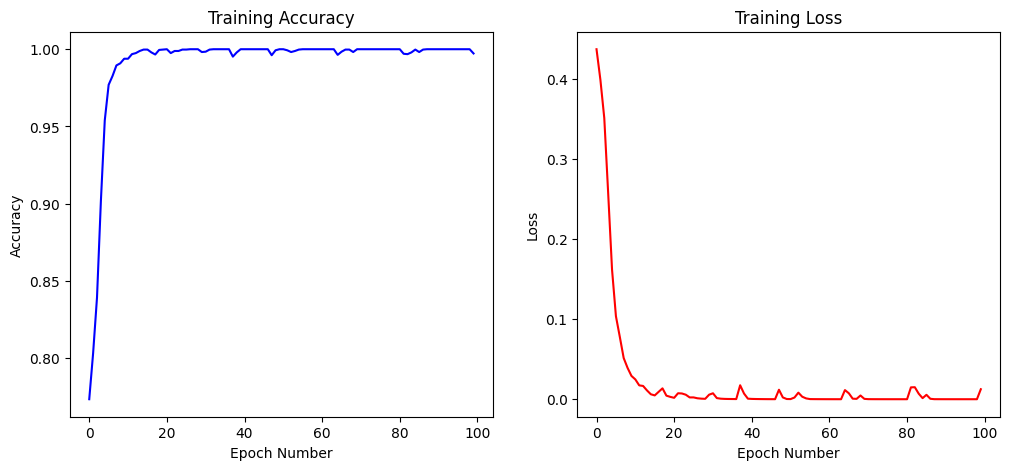

In [11]:
# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_accuracies, label='Accuracy', color='blue')
plt.title("Training Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.show()

In [9]:
# During inference / testing / deployment, we want to remove data augmentations from the input transform:
inference_preprocessing = transforms.Compose([ ResizeAndPad(target_size, 14),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                             ]
                                            )

In [19]:
n_100_correct_predictions = []

def inference_on_validation_data(inference_model, n_test_images=1):
    
    val_image_and_labels = data_loader(valid_dataset_dir, 1, image_dimension, 'inference')
    
    for img_and_label in val_image_and_labels:
        
        img_tensor, labels = img_and_label

        input_tensor = img_tensor.to(device)
        labels_tensor = labels.to(device)

        # run model on input image data
        with torch.no_grad():
            embeddings = inference_model.transformer(input_tensor)
            x = inference_model.transformer.norm(embeddings)
            output_tensor = inference_model.classifier(x)

            # sigmoid
            # score = output_tensor[0][0].item()
            # score = 1 / (1 + np.exp(-score))
            # 
            # # for binary classification, we can just interpret class name based on the 1 output score
            # predicted_class = class_names[1] if score > 0.5 else class_names[0]
            
            # Convert outputs to probabilities using sigmoid
            probabilities = torch.sigmoid(output_tensor)
            # Convert probabilities to predicted classes
            predicted_classes = probabilities > 0.5
            # Calculate accuracy
            n_labels = labels.size(1)
            correct_predictions = ((predicted_classes == labels_tensor.byte()).sum().item()) / n_labels
            
            if correct_predictions == 1.0:
                n_100_correct_predictions.append('c')

            # print(f"Prediction: {predicted_classes} | # Correct: {correct_predictions}" )

            print("\n\n\nDinoV2 Correct percent = {} | Predicted = {} vs. Ground Truth = {}:".format(correct_predictions, predicted_classes.tolist(), labels.tolist()))
            # plt.imshow(img)
            # plt.show()

In [10]:
# reloading the model with trained classification weights to demonstrate deployment
classifier = DinoVisionTransformerClassifier("base")

classifier.load_state_dict(torch.load('{}/classifier.pth'.format(local_directory)))

classifier = classifier.to(device)
classifier.eval()

DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, in

In [20]:
# Images from Creative Commons
# https://upload.wikimedia.org/wikipedia/commons/0/03/Lurie_Garden_%28Piet_Oudolf%29_-_Millennium_Park_-_Chicago_IL_%287833308160%29.jpg
# https://upload.wikimedia.org/wikipedia/commons/9/94/Adjoining_Industrial_Buildings_in_10-12-14_Ej%C3%A9rcito_Espa%C3%B1ol_street%2C_Valencia.jpg

inference_on_validation_data(inference_model=classifier, n_test_images=10)

print(f"# 100% correct predictions: {n_100_correct_predictions}")

1/457 | Loading image: gsv-chicago-10241-SurfaceProblem.png
2/457 | Loading image: gsv-chicago-10378-SurfaceProblem.png
3/457 | Loading image: gsv-chicago-10408-SurfaceProblem.png
4/457 | Loading image: gsv-chicago-10468-SurfaceProblem.png
5/457 | Loading image: gsv-chicago-10548-SurfaceProblem.png
6/457 | Loading image: gsv-chicago-10628-SurfaceProblem.png
7/457 | Loading image: gsv-chicago-10635-SurfaceProblem.png
8/457 | Loading image: gsv-chicago-10715-SurfaceProblem.png
9/457 | Loading image: gsv-chicago-10716-SurfaceProblem.png
10/457 | Loading image: gsv-chicago-10767-SurfaceProblem.png
11/457 | Loading image: gsv-chicago-10781-SurfaceProblem.png
12/457 | Loading image: gsv-chicago-10825-SurfaceProblem.png
13/457 | Loading image: gsv-chicago-10827-SurfaceProblem.png
14/457 | Loading image: gsv-chicago-10829-SurfaceProblem.png
15/457 | Loading image: gsv-chicago-10845-SurfaceProblem.png
16/457 | Loading image: gsv-chicago-10848-SurfaceProblem.png
17/457 | Loading image: gsv-chica